In [1]:
from typing import TypedDict, Optional, List

class AgentState(TypedDict):
    """그래프 상태를 나타내는 클래스."""
    url: str
    selector: str
    content: Optional[str]
    extracted_elements: Optional[List[str]]

In [2]:
import requests

# 웹페이지 로딩 노드
def fetch_webpage_content(state: AgentState):
    """URL에서 웹페이지 콘텐츠를 가져오는 함수."""
    print("웹페이지 콘텐츠 로딩 중...")
    url = state["url"]
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        state["content"] = response.text
    except requests.exceptions.RequestException as e:
        print(f"웹페이지 로딩 오류: {e}")
        state["content"] = None
    return state

In [3]:
from bs4 import BeautifulSoup

def extract_html_elements(state: AgentState):
    """웹페이지 콘텐츠에서 특정 HTML 요소를 추출하고 outerHTML을 반환하는 함수."""
    print("HTML 요소 추출 중...")
    if not state["content"]:
        state["extracted_elements"] = None
        return state

    try:
        soup = BeautifulSoup(state["content"], 'html.parser')
        elements = soup.select(state["selector"])
        
        extracted_html_list = []
        for element in elements:
            extracted_html_list.append(element.prettify())
            
        state["extracted_elements"] = extracted_html_list
    except Exception as e:
        print(f"HTML 요소 추출 오류: {e}")
        state["extracted_elements"] = None

    return state

In [4]:
def generate_output(state: AgentState):
    """분석 결과를 최종 출력하는 함수."""
    print("결과 생성 중...")
    if state["extracted_elements"]:
        print("\n--- 추출된 HTML 요소 텍스트 ---")
        for i, text in enumerate(state["extracted_elements"]):
            print(f"{i+1}. {text[:100]}...")  # 긴 텍스트는 일부만 출력
    else:
        print("\n--- 추출 실패 ---")
        print("요소를 찾을 수 없거나 오류가 발생했습니다.")
    return state

In [8]:
from langgraph.graph import StateGraph, END, START

# 그래프 생성
graph_builder = StateGraph(AgentState)

# 노드 추가 (fetch_content와 extract_html_elements, generate_output)
graph_builder.add_node("fetch_content", fetch_webpage_content)
graph_builder.add_node("extract_html_elements", extract_html_elements)
graph_builder.add_node("generate_output", generate_output)

# 엣지 연결
# graph_builder.add_edge(START, "fetch_content")
graph_builder.set_entry_point("fetch_content")
graph_builder.add_edge("fetch_content", "extract_html_elements")
graph_builder.add_edge("extract_html_elements", "generate_output")
graph_builder.add_edge("generate_output", END)

# 그래프 컴파일
graph = graph_builder.compile()

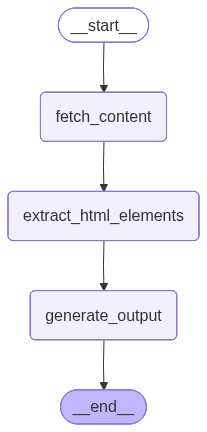

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
# 그래프 실행
# 추출을 원하는 HTML 요소를 CSS 셀렉터로 지정
inputs = {
    "url": "https://www.anthropic.com/engineering/building-effective-agents",
    "selector": ".display-sans-xl.bold"
}
result = graph.invoke(inputs)

print("\nLangGraph 실행 완료.")

웹페이지 콘텐츠 로딩 중...
HTML 요소 추출 중...
결과 생성 중...

--- 추출된 HTML 요소 텍스트 ---
1. <h1 class="display-sans-xl bold">
 Building effective agents
</h1>
...

LangGraph 실행 완료.
